<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo Seasonal ARIMA (SARIMA) e Grid Search Stepwise</font></b></strong>

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

A Média Móvel Integrada Autoregressiva Sazonal, SARIMA ou ARIMA Sazonal, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.

Esse modelo adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

__Elementos de Tendência:__

No modelo SARIMA existem três elementos de tendência que requerem configuração. Eles são iguais ao modelo ARIMA, especificamente:

- p: Ordem de regressão automática da tendência.
- d: Ordem de diferenciação da tendência.
- q: Ordem média móvel de tendência.

__Elementos de Sazonalidade:__

E temos mais quatro elementos sazonais que não fazem parte do ARIMA e que devem ser configurados no modelo SARIMA. Eles são:

- P: Ordem autoregressiva sazonal.
- D: Ordem da diferença sazonal.
- Q: Ordem da média móvel sazonal.
- m: O número de etapas de tempo para um único período sazonal. Por exemplo, um S de 12 para dados mensais sugere um ciclo sazonal anual.

__Notação SARIMA:__
SARIMA(p,d,q)(P,D,Q,m)

********* ATENÇÃO *********

Fique sempre atento às letras maiúsculas e minúsculas, pois isso faz toda diferença na interpretação dos parâmetros de ordem do modelo.

Criaremos algumas versões de modelo SARIMA a partir desta aula, para nosso problema de previsão de vendas, usando diferentes estratégias de Grid Search para busca dos valores ideais dos parâmetros de ordem.

O pacote pmdarima será útil em nosso trabalho: https://alkaline-ml.com/pmdarima/index.html

### Carregando os Pacotes Usados Neste Jupyter Notebook

In [1]:
# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import pmdarima as pm
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 12,7
matplotlib.style.use('ggplot')
%matplotlib inline

## Definição do Problema de Negócio

A HappyMoonVC é uma Venture Capital (VC).

Além do investimento no GoInRail (descrito nas aulas anteriores), a HappyMoonVC está analisando um outro negócio. Uma rede de varejo que poderá fornecer produtos para os clientes do GoInRail (drone elétrico para transporte de passageiros). 

Um monitor touch-screen dentro do GoInRail permitiria que o cliente fizesse a compra de produtos enquanto faz a viagem, com a opção de pegar o produto na estação que for descer ou então receber direto na residência (se acha que isso é futurista demais, saiba que já existe no metrô do Japão).

Para decidir se o investimento vale a pena, a HappyMoonVC precisa prever o volume de vendas.  

Esse é nosso trabalho.

## Conjunto de Dados

Usaremos conjuntos de dados que está disponível publicamente no site do Tableau e que representa as vendas históricas da empresa na qual a HappyMoonVC pretende investir. Aqui o link do dataset (que está sendo fornecido para você):

https://community.tableau.com/docs/DOC-1236

De todos os dados disponíveis, nosso interesse é na categoria de produtos de tecnologia.

In [2]:
# Carrega os dados
dados = pd.read_csv('data/vendasHistoricas.csv')

In [3]:
# Shape
dados.shape

(9994, 21)

In [4]:
# Colunas
dados.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

### Análise Exploratória

In [5]:
# Visualizando os dados
dados.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [6]:
# Resumo estatístico
dados.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [7]:
# Checando valores missing - não temos valores missing no dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [8]:
# Ajustando o nome das colunas para que todas fiquem com letras minúsculas
dados.columns = map(str.lower, dados.columns)

In [9]:
# Vamos substituir os espaços e traços nos nomes das colunas por '_'
dados.columns = dados.columns.str.replace(" ", "_")
dados.columns = dados.columns.str.replace("-", "_")

In [10]:
# Conferindo
dados.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [11]:
# Vamos checar os valores únicos por coluna (para ajudar a definir se a variável é categórica ou não)
for c in dados.columns:
    if len(set(dados[c])) < 20:
        print(c,set(dados[c]))

ship_mode {'First Class', 'Standard Class', 'Same Day', 'Second Class'}
segment {'Corporate', 'Home Office', 'Consumer'}
country {'United States'}
region {'Central', 'South', 'East', 'West'}
category {'Furniture', 'Office Supplies', 'Technology'}
sub_category {'Chairs', 'Art', 'Tables', 'Binders', 'Storage', 'Labels', 'Paper', 'Machines', 'Appliances', 'Copiers', 'Furnishings', 'Envelopes', 'Fasteners', 'Phones', 'Bookcases', 'Accessories', 'Supplies'}
quantity {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
discount {0.0, 0.8, 0.2, 0.3, 0.45, 0.5, 0.7, 0.6, 0.32, 0.1, 0.4, 0.15}


In [12]:
# Vamos checar as categorias de itens
#a = dados['category'].value_counts()
#fig = px.bar(a, x = a.index, y = a.values, height = 400)
#fig.update_layout(title = {'text': "Categorias de Itens", 
#                           'y':0.9,'x':0.5,'xanchor': 
#                           'center','yanchor': 'top'},
#                  xaxis_title = "Categoria",
#                  yaxis_title = "Total de Itens")
#fig.show(renderer = 'svg')

Vamos separar os dados por categoria (Móveis, Tecnologia, Material de escritório).

In [13]:
# Separando os dados por categoria
df_tecnologia = dados.loc[dados['category'] == 'Technology']
df_moveis = dados.loc[dados['category'] == 'Furniture']
df_office = dados.loc[dados['category'] == 'Office Supplies']

Agora vamos preparar as séries temporais.

In [14]:
# Agregando as vendas pela data do pedido
ts_tecnologia = df_tecnologia.groupby('order_date')['sales'].sum().reset_index()
ts_moveis = df_moveis.groupby('order_date')['sales'].sum().reset_index()
ts_office = df_office.groupby('order_date')['sales'].sum().reset_index()

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

In [15]:
# Como está ficando cada dataset?
ts_tecnologia

,order_date,sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


Vamos mover a data para o índice e assim criar a série temporal.

In [16]:
# Colocando a data como índice
ts_tecnologia = ts_tecnologia.set_index('order_date')

In [17]:
# Visualizando a série
ts_tecnologia

,sales
order_date,
2014-01-06,1147.940
2014-01-09,31.200
2014-01-13,646.740
2014-01-15,149.950
2014-01-16,124.200
...,...
2017-12-25,401.208
2017-12-27,164.388
2017-12-28,14.850


Agora podemos conferir a performance de vendas ao longo do tempo.

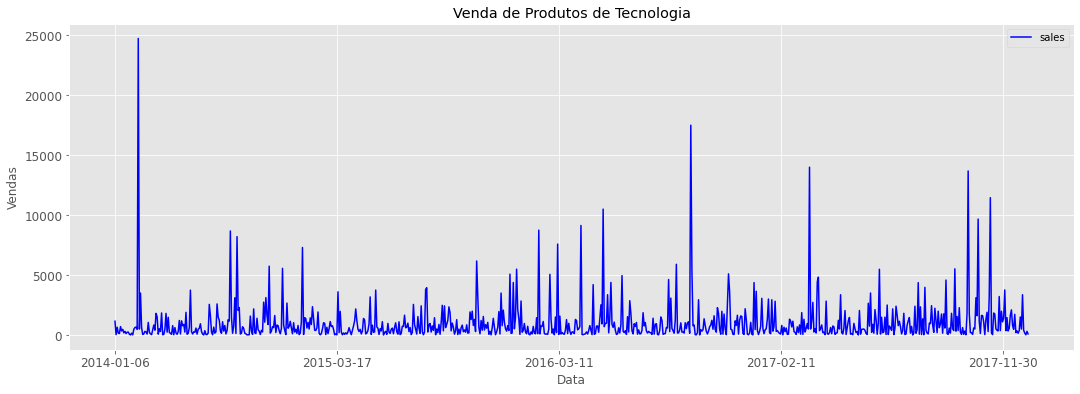

In [18]:
# Venda de Produtos de Tecnologia
vendas_tecnologia = ts_tecnologia[['sales']]
ax = vendas_tecnologia.plot(color = 'b', figsize = (18,6))
plt.xlabel("Data")
plt.ylabel('Vendas')
plt.title("Venda de Produtos de Tecnologia")
plt.show()

Vamos ajustar o indice do tipo Index para o tipo DateTimeIndex (o que caracteriza uma série temporal), pois faremos uma agregação pela média para analisar a venda média ao longo do tempo. 

In [19]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.base.Index

In [20]:
# Alterando o tipo do índice
vendas_tecnologia.index = pd.to_datetime(vendas_tecnologia.index)

In [21]:
# Conferindo o tipo do índice
type(vendas_tecnologia.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [22]:
# Reamostrando os dados para frequência mensal
# Usando o valor médio das vendas diárias - definimos o mês como índice
media_vendas_tecnologia = vendas_tecnologia['sales'].resample('MS').mean()

In [23]:
# Verificando o tipo resultante
type(media_vendas_tecnologia)

pandas.core.series.Series

In [24]:
# Checando os dados
media_vendas_tecnologia

order_date
2014-01-01     449.041429
2014-02-01     229.787143
2014-03-01    2031.948375
2014-04-01     613.028933
2014-05-01     564.698588
2014-06-01     766.905909
2014-07-01     533.608933
2014-08-01     708.435385
2014-09-01    2035.838133
2014-10-01     596.900900
2014-11-01    1208.056320
2014-12-01    1160.732889
2015-01-01     925.070800
2015-02-01     431.121250
2015-03-01     574.662333
2015-04-01     697.559500
2015-05-01     831.642857
2015-06-01     429.024400
2015-07-01     691.397733
2015-08-01    1108.902286
2015-09-01     950.856400
2015-10-01     594.716111
2015-11-01    1037.982652
2015-12-01    1619.637636
2016-01-01     374.671067
2016-02-01    1225.891400
2016-03-01    1135.150105
2016-04-01     875.911882
2016-05-01    1601.816167
2016-06-01    1023.259500
2016-07-01     829.312500
2016-08-01     483.620100
2016-09-01    1144.170300
2016-10-01    1970.835875
2016-11-01    1085.642360
2016-12-01     970.554870
2017-01-01    1195.218071
2017-02-01     430.501714
2

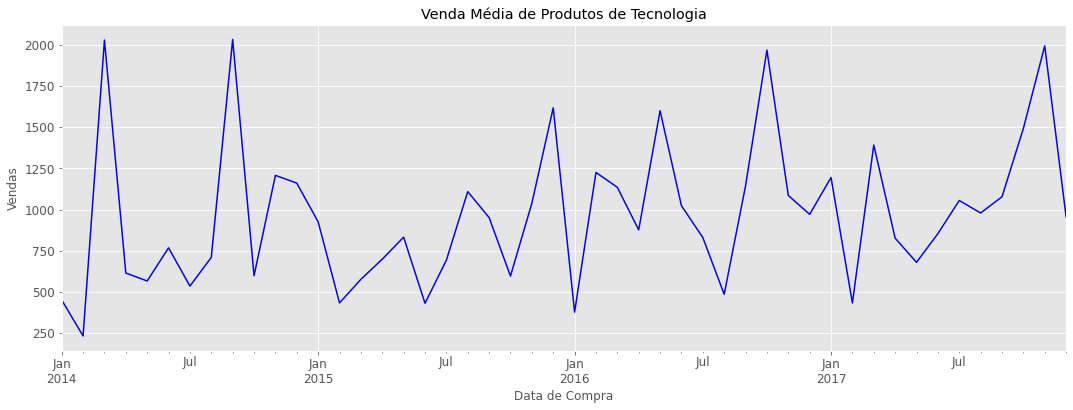

In [25]:
# Venda Média de Produtos de Tecnologia
media_vendas_tecnologia.plot(figsize = (18, 6), color = 'blue')
plt.xlabel("Data de Compra")
plt.ylabel('Vendas')
plt.title("Venda Média de Produtos de Tecnologia")
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

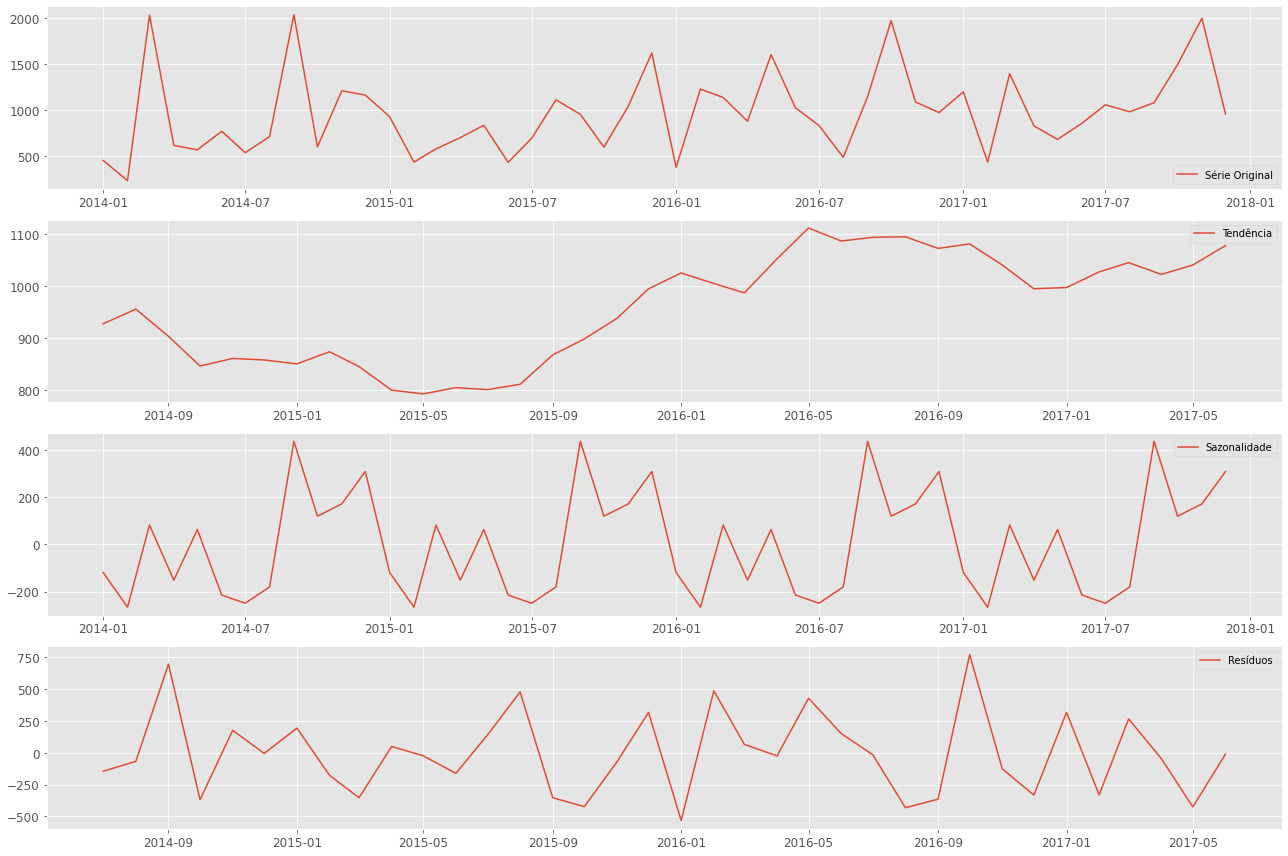

In [26]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(media_vendas_tecnologia, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(media_vendas_tecnologia, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [27]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

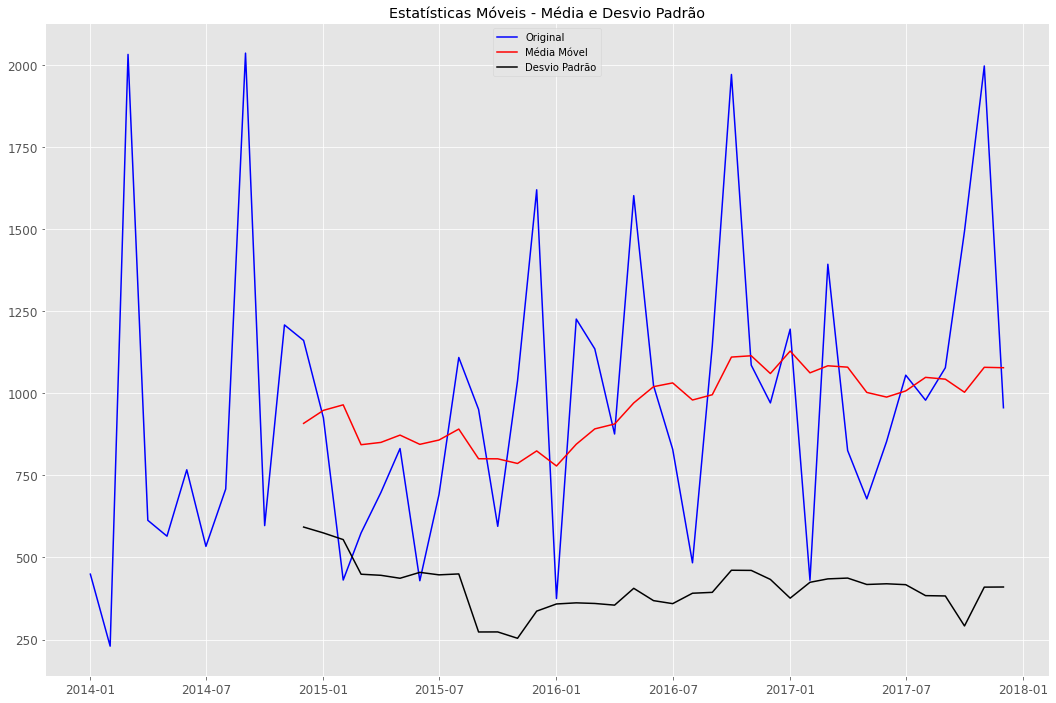


Resultado do Teste Dickey-Fuller:

Estatística do Teste           -7.187969e+00
Valor-p                         2.547334e-10
Número de Lags Consideradas     0.000000e+00
Número de Observações Usadas    4.700000e+01
Valor Crítico (1%)             -3.577848e+00
Valor Crítico (5%)             -2.925338e+00
Valor Crítico (10%)            -2.600774e+00
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [28]:
# Verifica se a série é estacionária
testa_estacionaridade(media_vendas_tecnologia)

### Dividindo os Dados em Treino e Teste

In [29]:
# Divisão em treino e teste
X = media_vendas_tecnologia
train_size = int(len(X) * 0.75)
trainset, testset = X[0:train_size], X[train_size:]

In [30]:
len(trainset)

36

In [31]:
len(testset)

12

### Função Para o Cálculo da Acurácia

In [32]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 2))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 2))+
                  '\nMAPE das previsões é {}'.format(round(mape, 2))))

Acesse o <a href="http://datascienceacademy.com.br/blog/">Blog da DSA</a> e fique por dentro das novidades em Data Science, Big Data, IA, RPA, Blockchain e mercado de trabalho.

## Modelo SARIMA

Até agora, restringimos nossa atenção aos dados não sazonais e aos modelos ARIMA não sazonais. No entanto, os modelos ARIMA também são capazes de modelar uma ampla variedade de dados sazonais.

A **Média Móvel Integrada Autoregressiva (ARIMA)** é um método de previsão para dados univariados de séries temporais.

Como o próprio nome sugere, ele suporta elementos médios autoregressivos e móveis. O elemento integrado refere-se à diferenciação, permitindo que o método suporte dados de séries temporais com uma tendência.

Um problema com o ARIMA é que ele não suporta dados sazonais, que é uma série temporal com um ciclo de repetição.

O ARIMA espera dados que não sejam sazonais ou que o componente sazonal seja removido, por exemplo, ajustado sazonalmente por métodos como diferenciação sazonal.

A **Média Móvel Integrada Autoregressiva Sazonal, SARIMA ou ARIMA Sazonal**, é uma extensão do ARIMA que suporta explicitamente dados de séries temporais univariadas com um componente sazonal.

Ele adiciona três novos hiperparâmetros para especificar a regressão automática (AR), a diferenciação (I) e a média móvel (MA) para o componente sazonal da série, além de um parâmetro adicional para o período da sazonalidade.

Um modelo ARIMA sazonal é formado pela inclusão de termos sazonais adicionais no ARIMA. A parte sazonal do modelo consiste em termos muito semelhantes aos componentes não sazonais do modelo, mas envolvem turnos alternados do período sazonal.

Um modelo ARIMA Sazonal é formado pela inclusão de termos sazonais adicionais nos modelos ARIMA que vimos até agora. Ou seja:

- Modelo ARIMA não sazonal = ARIMA(p, d, q)

- Modelo ARIMA sazonal = SARIMA(p,d,q)(P,D,Q,m)

Um modelo de média móvel integrada autoregressiva sazonal (SARIMA) é um passo diferente de um modelo ARIMA baseado no conceito de tendências sazonais. 

Em muitos dados de séries temporais, efeitos sazonais frequentes entram em cena. Tomemos, por exemplo, a temperatura média medida em um local com quatro estações. Haverá um efeito sazonal anualmente, e a temperatura nesta estação em particular definitivamente terá uma forte correlação com a temperatura medida no ano passado na mesma estação.

Considere o modelo SARIMA abaixo:

**SARIMA(3,1,0)(1,1,0)12**

O parâmetro m influencia os parâmetros P, D e Q. Por exemplo, um m de 12 para dados mensais sugere um ciclo sazonal anual.

O parâmetro P = 1 usaria a primeira observação sazonalmente deslocada no modelo, ou seja, t-(m * 1) ou t-12.

O parâmetro P = 2, usaria as duas últimas observações de compensação sazonal t-(m * 1), t-(m * 2).

Da mesma forma, um D de 1 calcularia uma diferença sazonal de primeira ordem e um Q = 1 usaria erros de primeira ordem no modelo (por exemplo, média móvel).

Um modelo ARIMA sazonal usa diferenciação em um atraso igual ao número de seasons para remover efeitos sazonais aditivos. Assim como na diferenciação do atraso 1 para remover uma tendência, a diferenciação do atraso introduz um termo médio móvel. O modelo ARIMA sazonal inclui termos médios autoregressivos e móveis em lag s.

### Grid Search Método 1 - Stepwise Search 

Usando um Modelo Auto-Arima para retornar os melhores parâmetros de ordem da série, para o menor valor possível da Estatística AIC.

Fazer uma análise manual completa de séries temporais pode ser uma tarefa tediosa, especialmente quando você tem muitos conjuntos de dados para analisar. É preferível automatizar a tarefa de seleção de modelo com a pesquisa em grade (Grid Search). Para o SARIMA, como temos muitos parâmetros, a pesquisa em grade pode levar horas para ser concluída em um conjunto de dados se definirmos o limite de cada parâmetro muito alto. Definir limites muito altos também tornará seu modelo muito complexo e superestimará os dados de treinamento.

Para evitar o longo tempo de execução e o problema de sobreajuste (overfitting), aplicamos o que é conhecido como princípio de parcimônia, onde criamos uma combinação de todos os parâmetros tais que p + d + q + P + D + Q ≤ 6. Outra abordagem é definir cada parâmetro como 0 ou 1 ou 2 e fazer a pesquisa na grade usando o AIC em cada combinação. 

Usaremos a segunda opção, chamada Grid Search Stepwise. Vou definir limites pequenos para os hiperparâmetros, mas você pode testar outros valores se desejar.

In [33]:
# Buscando pela ordem ideal para o modelo
# A função pm.auto_arima aplica o Grid Search e retorna o melhor modelo
modelo_v1 = pm.auto_arima(trainset,
                          seasonal = True, 
                          m = 12,
                          d = 0, 
                          D = 1, 
                          max_p = 2, 
                          max_q = 2,
                          trace = True,
                          error_action = 'ignore',
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=384.657, Time=0.46 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=380.244, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=378.184, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=378.609, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=382.218, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=377.369, Time=0.12 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.43 sec
 AR

Analisando o resultado do Grid Search Stepwise percebemos que este é o melhor modelo:
    
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 12) (constant=True); AIC=376.765, BIC=380.299, Time=0.094 seconds

Melhor Modelo: 

- arima_order = (0, 0, 0)

- seasonal_order = (0, 1, 1, 12)

- AIC = 376.765

In [34]:
# Print do sumário do melhor modelo encontrado
print(modelo_v1.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 12)   Log Likelihood                -184.398
Date:                             Tue, 14 Jun 2022   AIC                            376.797
Time:                                     11:20:01   BIC                            381.509
Sample:                                          0   HQIC                           378.047
                                              - 36                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    163.5163     74.251      2.202      0.028      17.986     309.046
ma.L1         -0.4516      

Vamos então usar os valores encontrados pelo Grid Search e treinar um modelo SARIMA.

A implementação no Statsmodels é chamada SARIMAX em vez de SARIMA e a adição de "X" ao nome do método significa que a implementação também suporta variáveis exógenas.

Essas são variáveis de séries temporais paralelas que não são modeladas diretamente pelos processos AR, I ou MA, mas são disponibilizadas como entrada ponderada para o modelo.

Variáveis exógenas são opcionais e podem ser especificadas através do argumento “exog”.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [35]:
# Cria o Modelo SARIMA
modelo_sarima_v1 = sm.tsa.statespace.SARIMAX(trainset,
                                             order = (0, 0, 0),
                                             seasonal_order = (0, 1, 1, 12),
                                             enforce_stationarity = False,
                                             enforce_invertibility = False)

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.fit.html

In [36]:
# Treinamento (Fit) do modelo
modelo_sarima_v1_fit = modelo_sarima_v1.fit()

In [37]:
# Sumário do modelo
print(modelo_sarima_v1_fit.summary())

                                 SARIMAX Results                                  
Dep. Variable:                      sales   No. Observations:                   36
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                 -86.367
Date:                    Tue, 14 Jun 2022   AIC                            176.735
Time:                            11:20:06   BIC                            177.531
Sample:                        01-01-2014   HQIC                           176.233
                             - 12-01-2016                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.3774      1.009     -0.374      0.708      -2.355       1.600
sigma2      3.615e+05   1.47e+05      2.451      0.014    7.25e+04    6.51e+05
Ljung-Box (L1) (Q): 

Nas próximas aulas vamos interpretar o sumário do modelo e comparar as versões dos modelos SARIMA que iremos criar.

Mas perceba o valor de AIC. Conseguimos reduzí-lo de forma considerável e a única mudança foi a troca do modelo ARIMA não sazonal pelo modelo ARIMA sazonal, o SARIMA. Saber escolher o modelo ideal a cada problema requer conhecimento sobre o maior número possível de modelos, o que sempre procuramos trazer nos cursos da Data Science Academy.

In [38]:
# Diagnóstico do modelo
modelo_sarima_v1_fit.plot_diagnostics(figsize = (16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

Nas próximas aulas vamos interpretar esse diagnóstico e comparar as versões dos modelos SARIMA que iremos criar.

Uma vez ajustado, o modelo pode ser usado para fazer previsões.

Uma previsão pode ser feita chamando as funções forecast() ou predict() no objeto SARIMAXResults retornado do treinamento do modelo. Alternativamente podemos usar get_forecast() ou get_predict() se quisermos mais detalhes das previsões.

A função forecast() usa um único parâmetro que especifica o número de etapas de tempo fora da amostra a serem previstas ou assume uma previsão de uma etapa se nenhum argumento for fornecido.

A função predict faz o mesmo que forecast(), mas com uma limitação de sete passos no tempo.

In [39]:
# Vamos fazer previsões um passo a frente
sarima_predict_1 = modelo_sarima_v1_fit.get_prediction(start = pd.to_datetime('2017-01-01'), 
                                                       end = pd.to_datetime('2017-12-01'),
                                                       dynamic = False)

In [40]:
# Intervalo de confiança
sarima_predict_conf_1 = sarima_predict_1.conf_int()
sarima_predict_conf_1

,lower sales,upper sales
2017-01-01,-639.998357,1732.840686
2017-02-01,-276.155115,2083.374137
2017-03-01,-85.221819,2274.307432
2017-04-01,-385.161919,1974.367332
2017-05-01,98.276918,2457.806169
2017-06-01,-340.633732,2018.895519
2017-07-01,-425.326643,1934.202609
2017-08-01,-518.980867,1840.548384
2017-09-01,13.644086,2373.173337
2017-10-01,275.522373,2635.051625


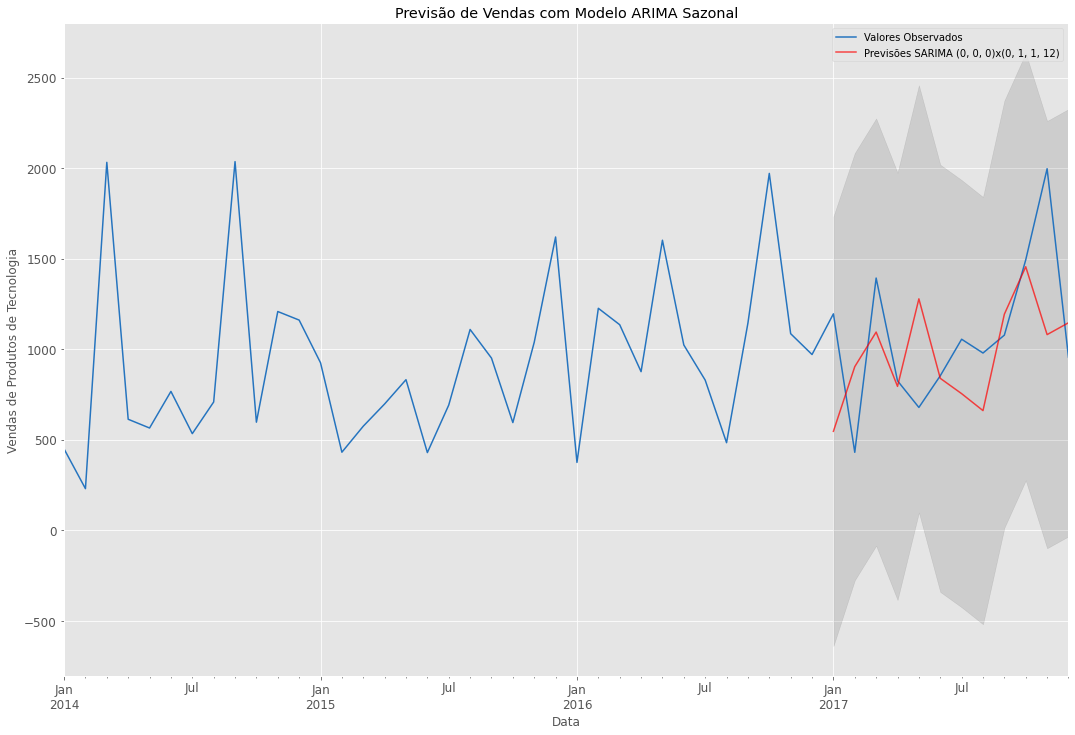

In [41]:
# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados', color = '#2574BF')

# Plot dos valores previstos
sarima_predict_1.predicted_mean.plot(ax = ax, 
                                     label = 'Previsões SARIMA (0, 0, 0)x(0, 1, 1, 12)', 
                                     alpha = 0.7, 
                                     color = 'red') 

# Plot do intervalo de confiança
ax.fill_between(sarima_predict_conf_1.index,
                # lower sales
                sarima_predict_conf_1.iloc[:, 0],
                # upper sales
                sarima_predict_conf_1.iloc[:, 1], color = 'k', alpha = 0.1)

# Títulos e Legendas
plt.title('Previsão de Vendas com Modelo ARIMA Sazonal')
plt.xlabel('Data')
plt.ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

Embora ainda não esteja ideal, o modelo fez um bom trabalho nas previsões.

In [42]:
# Calculando a performance
sarima_results = performance(testset, sarima_predict_1.predicted_mean)
sarima_results

MSE das previsões é 181383.68
RMSE das previsões é 425.89
MAPE das previsões é 34.95


O erro do modelo aumentou um pouco, mas não podemos usar apenas uma medida para avaliar o modelo. Falaremos mais sobre isso nas aulas seguintes. Vejamos como o modelo se sai em um horizonte de previsão maior.

In [43]:
# Forecast (previsão) de 60 passos no tempo
horizonte_60_predict_1 = modelo_sarima_v1_fit.get_forecast(steps = 60)

In [44]:
# Intervalo de confiança
horizonte_60_predict_1_conf_1 = horizonte_60_predict_1.conf_int()
horizonte_60_predict_1_conf_1

,lower sales,upper sales
2017-01-01,-639.998357,1732.840686
2017-02-01,-276.155115,2083.374137
2017-03-01,-85.221819,2274.307432
2017-04-01,-385.161919,1974.367332
2017-05-01,98.276918,2457.806169
2017-06-01,-340.633732,2018.895519
2017-07-01,-425.326643,1934.202609
2017-08-01,-518.980867,1840.548384
2017-09-01,13.644086,2373.173337
2017-10-01,275.522373,2635.051625


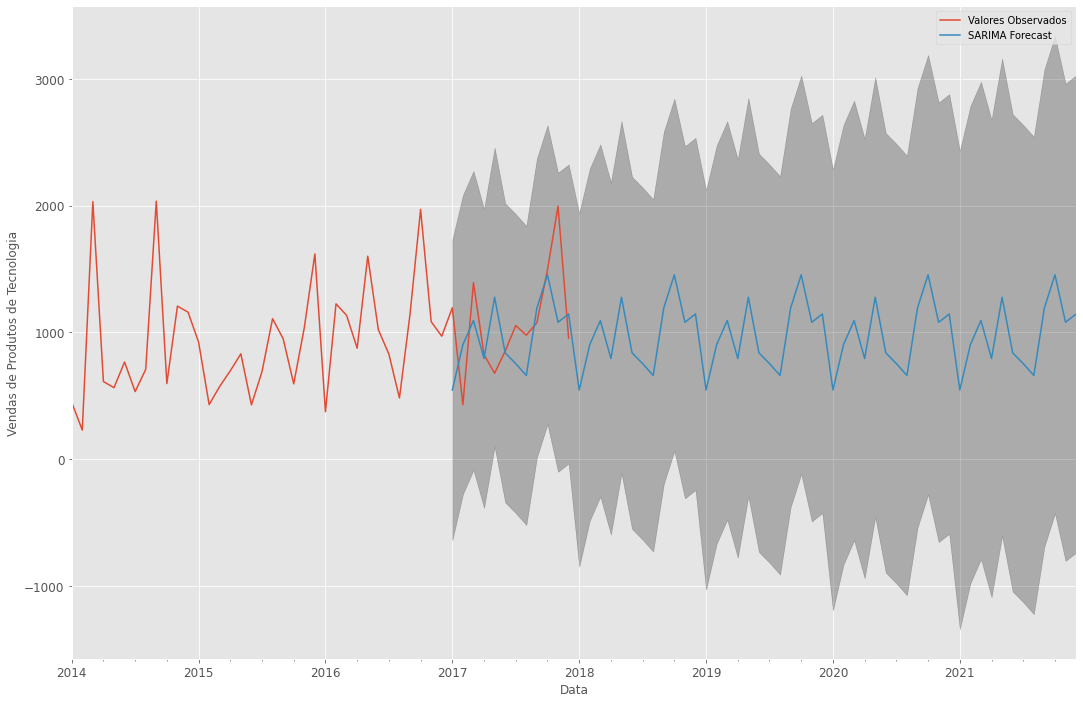

In [45]:
# Plot dos valores observados
ax = media_vendas_tecnologia.plot(label = 'Valores Observados')

# Plot dos valores previstos
horizonte_60_predict_1.predicted_mean.plot(ax = ax, label = 'SARIMA Forecast')

# Plot do intervalo de confiança
ax.fill_between(horizonte_60_predict_1_conf_1.index,
                horizonte_60_predict_1_conf_1.iloc[:, 0],
                horizonte_60_predict_1_conf_1.iloc[:, 1], color = 'k', alpha = .25)

# Plot
ax.set_xlabel('Data')
ax.set_ylabel('Vendas de Produtos de Tecnologia')
plt.legend()
plt.show()

Por que a área cinza aumenta? Porque quanto maior o horizonte de previsão, maior a incerteza das previsões. Veja que estamos fazendo previsões de vendas para 5 anos (60 passos no tempo em nossa série), o que aumenta a incerteza a cada novo passo de tempo previsto.

In [46]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_sarima_v1_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [0.7226462]


Observe que o valor-p é maior que 0,05, o que indica que os resíduos são independentes no nível de 95%. 

E, portanto, um modelo SARIMA(0, 0, 0)x(0, 1, 1, 12) fornece um bom ajuste e boa capacidade de previsão.

Como estamos até agora:
    
- Aula 15 --> Modelo ARMA (1,1) - AIC = 550.3 e RMSE = 420.2
- Aula 16 --> Modelo ARIMA (6,0,2) - AIC = 559.4 e RMSE = 401.5
- Aula 17 --> Modelo SARIMA(0, 0, 0)x(0, 1, 1, 12)  - AIC = 176.74 e RMSE = 425.89

Mesmo com o leve aumento no erro do modelo em relação às versões anteriores, a performance do modelo SARIMA é bem superior, o que fica evidenciado pela redução da Estatística AIC.

Seríamos capazes de melhorar a performance do modelo SARIMA?